### Requirements to use notebook:
    1. fastai environment
    2. dataset-resized file from: https://drive.google.com/open?id=0B3P9oO5A3RvSNWw5X0c5R1hJRnc
    3. personal AMLI dataset from: <to do>

## This jupyter notebook will be dedicated to training the model via the resnet34 model
Note that the **Original Trashnet Dataset (OTD)** includes only **6 classes** (no E-Waste). Therefore, we want to include E-Waste in the initial training in order to preform proper transfer learning later on.
The OTD also has a rather unique methodology that doesn't extrapolate well to our use case. Specifically, the background of every image is a white posterboard. In addition, the items themselves have been manually zoomed/cropped. (a good example is below).

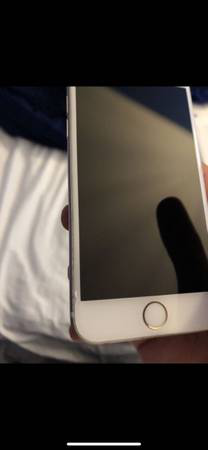

In [36]:
import os
from PIL import Image
path = os.path.join(os.getcwd(), 'dataset-resized', 'glass', 'glass298.jpg')
Image.open(path)
path = ('AMLI-trashnet/E-Waste/E-Waste (1).jpg')
img = cv.imread(path)
r_img = cv.resize(img, new_size)
Image.open(path)

In order to construct a model that will not just test well (high testing accuracy), but also high use-case accuracy, we need to make sure that the images included in the dataset include a variety of images. This variety will include both white posterboard backgrounds and more natural backgrounds (as was taken in our AMLI dataset).

Let us first take a moment to explore our use-case:
    - A user will be accessing our model via an app. 
    - They will take a photo of an item they are holding in their hand, or an item they have placed down on a coun-tertop/etc. 
    - Then our model will need to both be able to distinguish the item from the background and be able to identify whether or not it is a recyclable material. 

Therefore, we need to include images with more noise in the training for our model (specifically images with noise in the background)

Note that our model will be following a similar direction as the following jupyter notebook: https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb
<br>Main Differences: <br>
1. 

# 1. Extract Data from Bucket

Please note that we are running our model through a google VM instance. Therefore, we extract our data from a bucket. Our dataset and the resized trashnet dataset will be available via google drive zip files.

In [2]:
!gsutil ls

gs://amli_trashnet_photos/
gs://original-data-amli/


In [3]:
!gsutil ls gs://original-data-amli/

gs://original-data-amli/dataset-original.zip
gs://original-data-amli/AMLI-newtrashnet/
gs://original-data-amli/AMLI-trashnet 2/
gs://original-data-amli/AMLI-trashnet/
gs://original-data-amli/Trashnet2/
gs://original-data-amli/dataset-original/
gs://original-data-amli/dataset-resized/


In [4]:
#!gsutil ls gs://amli_trashnet_photos/

In [12]:
!gsutil -q cp -r gs://amli_trashnet_photos/AMLI-trashnet/ .

In [6]:
#!gsutil -q cp -r gs://original-data-amli/dataset-resized .

In [7]:
# !gsutil -q cp -r gs://original-data-amli/AMLI-trashnet/ .

In [8]:
# !gsutil -q cp -r gs://original-data-amli/AMLI-trashnet\ 2/ .

# 2. Imports and Organize images into different folders

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [14]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import cv2 as cv
import pandas as pd
import numpy as np
import shutil
import random
import re
import seaborn as sns
import sys
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

At this point we have finished importing everything we will need. Next we will take the dataset-resized and 60% of the AMLI dataset and combine it into a single data folder with 3 subfolders (train, valid, test). Each folder will include the classes. Note that we include E-Waste, which will be done in a separate code that will first resize all of AMLI dataset in order to both get the model to include only images of a certain size and, more importantly, filter out through images that are not readable due to individual errors.

<br>Model_data<br>
$\;\;\;\;\;\;$    -> train <br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> plastic <br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> paper<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> cardboard<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> glass<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> metal<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> trash<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> E-Waste<br>
$\;\;\;\;\;\;$    -> valid <br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> plastic <br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> paper<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> cardboard<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> glass<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> metal<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> trash<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> E-Waste<br>
$\;\;\;\;\;\;$    -> test <br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> plastic <br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> paper<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> cardboard<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> glass<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> metal<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> trash<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$        -> E-Waste<br>

The below code will both resize, rename, and transfer the AMLI dataset into a new folder (resized_AMLI). This will allow for us to pass over images that may cause issues for being unreadable.

In [85]:
dataset_path = os.path.join('AMLI-trashnet')
path = os.path.join('resized_AMLI')
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash', 'E-Waste']
new_size = (384,512)

if not os.path.exists(path):
    os.mkdir(path)
    
'''
function: rename
input: subdirectory (type of waste in our case)
output: the same subdirectory but with each file named in a consistent fashion

e.g.
input: 'Cardboard'
output: -> Cardboard
            ->'Cardboard0.jpg'
            ->'Cardboard1.jpg'
            ...
            ->'Cardboard100.jpg' (Assuming 101 is the amount of images in the Cardboard subdirectory)
'''
def rename(waste): 
    i = 0
    file_path = os.path.join(path, waste)   #Remove 'Photo' since this will be called on Resized folder
    for filename in os.listdir(file_path): 
        newName = waste + str(i) + ".jpg"
        src = file_path+'/'+ filename 
        dst = file_path+ '/' + newName 
        os.rename(src, dst) 
        i += 1

def reset_rename(waste): 
    i = 0
    file_path = os.path.join(path, waste)
    for filename in os.listdir(file_path): 
        newName = 'a' + str(i) + ".jpg"
        src = file_path+'/'+ filename 
        dst = file_path+ '/' + newName 
        os.rename(src, dst) 
        i += 1        
        
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]
'''
function: resize
input: subdirectory (type of waste in our case)
output: go through Photos and V_Photos subdirectory and move resized images 
        into a new directory while disregarding any corrupt images

'''
def resize(waste):
    #create categories folder in resize dataset
    folder_path = os.path.join(dataset_path, waste)
    save_path = os.path.join(path, waste) 

    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    count = 0
    total = 0
    
    for folder in get_immediate_subdirectories(folder_path):
        file_path = os.path.join(folder_path,folder)
        for filename in os.listdir(file_path):
            img = cv.imread(os.path.join(file_path,filename))
            total += 1
            if img is None:
                count += 1
                continue
            
            r_img = cv.resize(img, new_size)
            cv.imwrite(os.path.join(save_path,filename), r_img)
    
    print(waste, 'photos have', count, 'corrupted files out of', total)   
    return
  
for waste in waste_types:
    resize(waste) 

for waste in waste_types:
    reset_rename(waste)
    rename(waste)

Cardboard photos have 1 corrupted files out of 199
Glass photos have 2 corrupted files out of 637
Metal photos have 2 corrupted files out of 880
Paper photos have 14 corrupted files out of 191
Plastic photos have 21 corrupted files out of 376
Trash photos have 0 corrupted files out of 285
E-Waste photos have 2 corrupted files out of 439


Let us gather a bit more information about the dataset. For example, how many of each type do we have in both the original trashnet dataset, our new AMLI dataset, and the resized AMLI dataset

In [86]:
print('--->  original-trashnet')
original = os.path.join('dataset-resized')
class_dict = {'trash':0, 'plastic':0, 'paper':0, 'metal':0, 'glass':0, 'cardboard':0}
classes = list(class_dict.keys())
for i in classes:
    for file in os.listdir(os.path.join(original, i)):
        class_dict[i] += 1
    print(i,'has count',class_dict[i])
    
print('--->  amli-trashnet')
amli = os.path.join('AMLI-trashnet')
class_dict_amli = {'Trash':0, 'Plastic':0, 'Paper':0, 'Metal':0, 'Glass':0, 'Cardboard':0, 'E-Waste':0}
classes = list(class_dict_amli.keys())
for i in classes:
    for folder in get_immediate_subdirectories(os.path.join(amli, i)):
        file_path = os.path.join(amli,i, folder)
        for filename in os.listdir(file_path):
            class_dict_amli[i] += 1
    print(i,'has count',class_dict_amli[i])
    
print('--->  resized_AMLI')
amli = os.path.join('resized_AMLI')
class_dict_re = {'Trash':0, 'Plastic':0, 'Paper':0, 'Metal':0, 'Glass':0, 'Cardboard':0, 'E-Waste':0}
classes = list(class_dict_re.keys())
for i in classes:
    for file in os.listdir(os.path.join(amli, i)):
        class_dict_re[i] += 1
    print(i,'has count',class_dict_re[i])    

--->  original-trashnet
trash has count 137
plastic has count 482
paper has count 594
metal has count 410
glass has count 501
cardboard has count 403
--->  amli-trashnet
Trash has count 285
Plastic has count 376
Paper has count 191
Metal has count 880
Glass has count 637
Cardboard has count 199
E-Waste has count 439
--->  resized_AMLI
Trash has count 285
Plastic has count 355
Paper has count 177
Metal has count 878
Glass has count 598
Cardboard has count 198
E-Waste has count 437


As we can see, our resized_AMLI is slightly smaller than AMLI-trashnet due to a few corrupted files.

In [87]:
'''
function: get_indices
input: specific directory w/ n images
output: a list of indices with a size of .6*n
'''
def get_indices(folder):
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))
    train = random.sample(list(range(1,n+1)), int(.6*n))
    return train
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash', 'E-Waste']
d = {}
for waste in waste_types:
    l = get_indices(os.path.join('resized_AMLI', waste))
    d[waste] = l
    print(waste, ':', len(l))


Cardboard : 118
Glass : 358
Metal : 526
Paper : 106
Plastic : 213
Trash : 171
E-Waste : 262


In [88]:
'''
Combine resized trashnet and resized AMLI in a new file called total_data
'''
dest = 'total_data'
for waste in waste_types:
    save_path = os.path.join(dest,waste)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # Populate it with all of original trashnet first
    if(waste != 'E-Waste'):
        source = os.path.join('dataset-resized', waste.lower())
        for file in os.listdir(source):
            img = cv.imread(os.path.join(source,file))
            cv.imwrite(os.path.join(save_path,file), img)
    # Now populate it with the indices from our previous function
    amli_source = os.path.join('resized_AMLI', waste)
    ignore = '.ipynb_checkpoints'
    count = 0
    index = 0
    for file in os.listdir(amli_source):
        index += 1
        # Using index instead of the below because it does not
        # break as often and is consistent with the randomness of our sampling
        if(file == ignore):
            index -= 1
            continue
        if(index in d[waste]):
            count += 1
            img1 = cv.imread(os.path.join(amli_source, file))    
            cv.imwrite(os.path.join(save_path,file), img1)


Next, in order to make sure there are no more corrupt files, we will double check every file in total data and delete those that are corrupt.

In [89]:
path = Path(os.getcwd())/"total_data"
cnt=0
ignore = '.ipynb_checkpoints'
for waste in waste_types:
    temp = os.path.join(path,waste)
    for filename in os.listdir(temp):
        if(filename == ignore):
            continue
        file = os.path.join(temp,filename)
        try:
            img=Image.open(file)
        except OSError:
            print("FILE: ", filename, "is corrupt!")
            cnt+=1
            os.remove(file)
    print('Done w/',waste,':', cnt, 'corrupted files')

Done w/ Cardboard : 0 corrupted files
Done w/ Glass : 0 corrupted files
Done w/ Metal : 0 corrupted files
Done w/ Paper : 0 corrupted files
Done w/ Plastic : 0 corrupted files
Done w/ Trash : 0 corrupted files
Done w/ E-Waste : 0 corrupted files


In [90]:
''' 
function: split_indices
    goal: splits indices for a folder into train, validation, and test indices with random sampling
    input: folder path
    output: train, valid, and test indices
    '''    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(0,n))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(0,n)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

'''
function: get_names
    input: waste category and indices
    output: list of file names for a particular type of trash, given indices
    '''
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

''' 
function: copy_files
     input: list of source files and destination folder
     output: none, but it copies group of source files to another folder
     '''
def copy_files(source_files,destination_folder):
    for file in source_files:
        shutil.copy(file, destination_folder)

In [91]:
## paths will be train/Cardboard, train/Glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash', 'E-Waste']

In [92]:
print('--->  total_data')
total = os.path.join('total_data')
class_dict_total = {'Cardboard':0, 'Glass':0, 'Metal':0, 'Paper':0, 'Plastic':0, 'Trash':0, 'E-Waste':0}
classes = list(class_dict_total.keys())
for i in classes:
    for file in os.listdir(os.path.join(total, i)):
        class_dict_total[i] += 1
    print(i,'has count',class_dict_total[i])

--->  total_data
Trash has count 308
Plastic has count 695
Paper has count 700
Metal has count 936
Glass has count 859
Cardboard has count 521
E-Waste has count 262


In [93]:
path = os.path.join('total_data')

for waste in waste_types:
    reset_rename(waste)
    rename(waste)

In [94]:
print('--->  total_data')
total = os.path.join('total_data')
class_dict_total = {'Cardboard':0, 'Glass':0, 'Metal':0, 'Paper':0, 'Plastic':0, 'Trash':0, 'E-Waste':0}
classes = list(class_dict_total.keys())
for i in classes:
    for file in os.listdir(os.path.join(total, i)):
        class_dict_total[i] += 1
    print(i,'has count',class_dict_total[i])

--->  total_data
Cardboard has count 521
Glass has count 859
Metal has count 936
Paper has count 700
Plastic has count 695
Trash has count 308
E-Waste has count 262


In [95]:
## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('Model_data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('total_data',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "Model_data/train/"+waste_type
    copy_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "Model_data/valid/"+waste_type
    copy_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "Model_data/test/"+waste_type
    ## Note that the files are being copied in order to make sure our original folder does not get modified
    copy_files(test_source_files,test_dest)

--->  Model_data
Trash has count 308
Plastic has count 695
Paper has count 700
Metal has count 936
Glass has count 859
Cardboard has count 521
E-Waste has count 262


<BarContainer object of 7 artists>

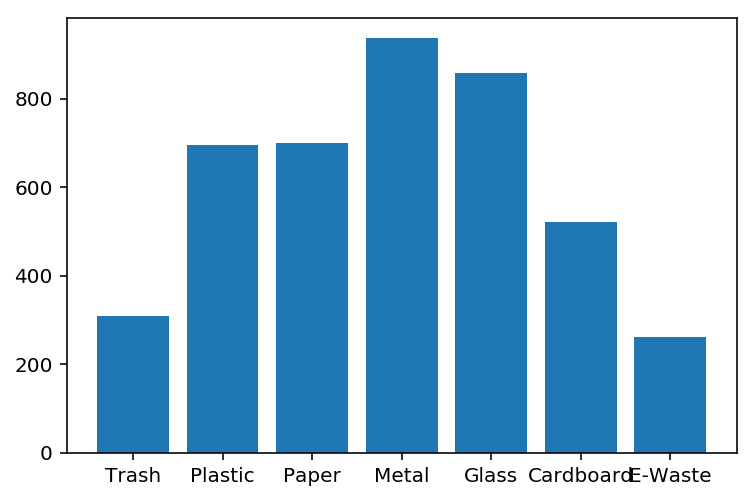

In [96]:
print('--->  Model_data')
total = os.path.join('total_data')
class_dict_total = {'Trash':0, 'Plastic':0, 'Paper':0, 'Metal':0, 'Glass':0, 'Cardboard':0, 'E-Waste':0}
classes = list(class_dict_total.keys())
for i in classes:
    for file in os.listdir(os.path.join(total, i)):
        class_dict_total[i] += 1
    print(i,'has count',class_dict_total[i])
x = classes
y = list(class_dict_total.values())
plt.bar(x,y)

The barplot above shows that are dataset is not evenely proportionate. We will try to get more E-Waste and Trash images in the future.

In [104]:
## get a path to the folder with images
path = Path(os.getcwd())/"Model_data"
path
# One final verification brought to us by fastai
for classification in path.iterdir():
    verify_images(classification, delete=True)

Now that we have the path to our data set, we will apply some data augmentation transforms in order to increase the amount of data we can train on. Note that we are currently only flipping horizontally. This is because we have included a mix of natural backgrounds with the whiteboard backgrounds. Therefore, flipping vertically will not be representable of something the model will ever encounter. In regards to our ImageDataBunch, we use a batch size of 16 and convert all images to (384, 512).

In [105]:
tfms = get_transforms(do_flip=True)
#include test so that I can test accuracy at the end of the model
data = ImageDataBunch.from_folder(path,train = 'train', valid = 'valid', test = 'test', ds_tfms=tfms,bs=16, size = (384,512)).normalize(imagenet_stats)

In [106]:
data

ImageDataBunch;

Train: LabelList (2139 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
Plastic,Plastic,Plastic,Plastic,Plastic
Path: /home/jupyter/Recycling/Model_data;

Valid: LabelList (1070 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
Plastic,Plastic,Plastic,Plastic,Plastic
Path: /home/jupyter/Recycling/Model_data;

Test: LabelList (1072 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/jupyter/Recycling/Model_data

In [57]:
print(data.classes)

['Cardboard', 'E-Waste', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']


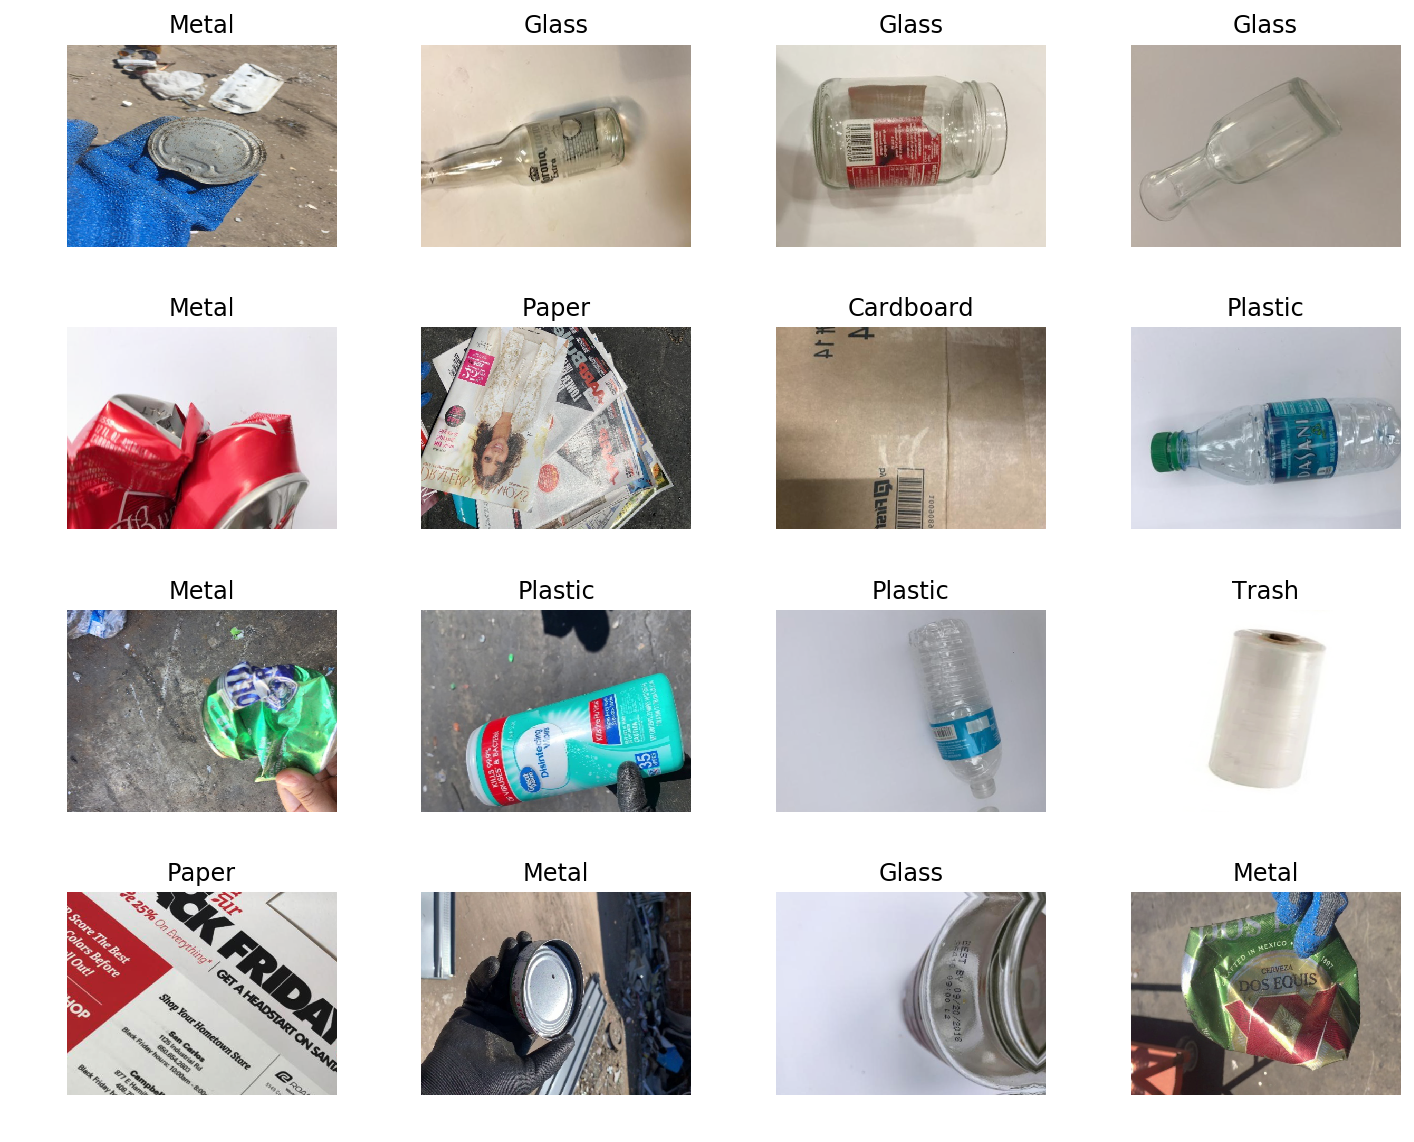

In [58]:
data.show_batch(rows=4,figsize=(10,8))


# 3. Model Training

We will be training with a resnet34 architecture, trying to minimize the error_rate. Note that we are using a Convolutional Neural Network. This is because, although we could use a classification algorithm, CNNs have shown to outpreform classifiers in accuracy. 

In [107]:
learn = cnn_learner(data,models.resnet34,metrics=accuracy, callback_fns=ShowGraph)

In [ ]:
learn.model

## 3.1 Find the ideal learning rate
One of the hyperparameters that we can change is known as the learning rate. This number tells our model how much new information should override old information. In order to find the ideal learning rate for our model, we will plot the learning rate vs. the loss.

In [108]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

AttributeError: 'numpy.float64' object has no attribute 'func'

As we can see, the minimum amount of loss (gradient) is inbetween 1e-02 and 1e-01. That being said, we will run with a default learning rate on 3 epochs first.

## 3.2 Training

In [ ]:
learn.fit_one_cycle(3)

Let us save this model, unfreeze it, and then learn on a sliced learning rate given by the recorder_plot

In [ ]:
learn.save('stage-1-rn34')

In [ ]:
learn.unfreeze()

In [ ]:
#now transfer learning to further improve
learn = learn.load('stage-1-rn34')

In [ ]:
learn.lr_find()
#....
learn.recorder.plot(suggestion = True)
#....discriminative learning rate (slicing lr)

In [ ]:
#learn.fit_one_cycle(16,max_lr=5.13e-03)
learn.fit_one_cycle(6,max_lr=slice(1e-06,1e-03) )

In [67]:
learn.save('stage-2-rn34')

## 3.3 Visualizing most incorrect images¶
Although our model currently has an error rate around 0.07, it is important to understand where our model has the most issues

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

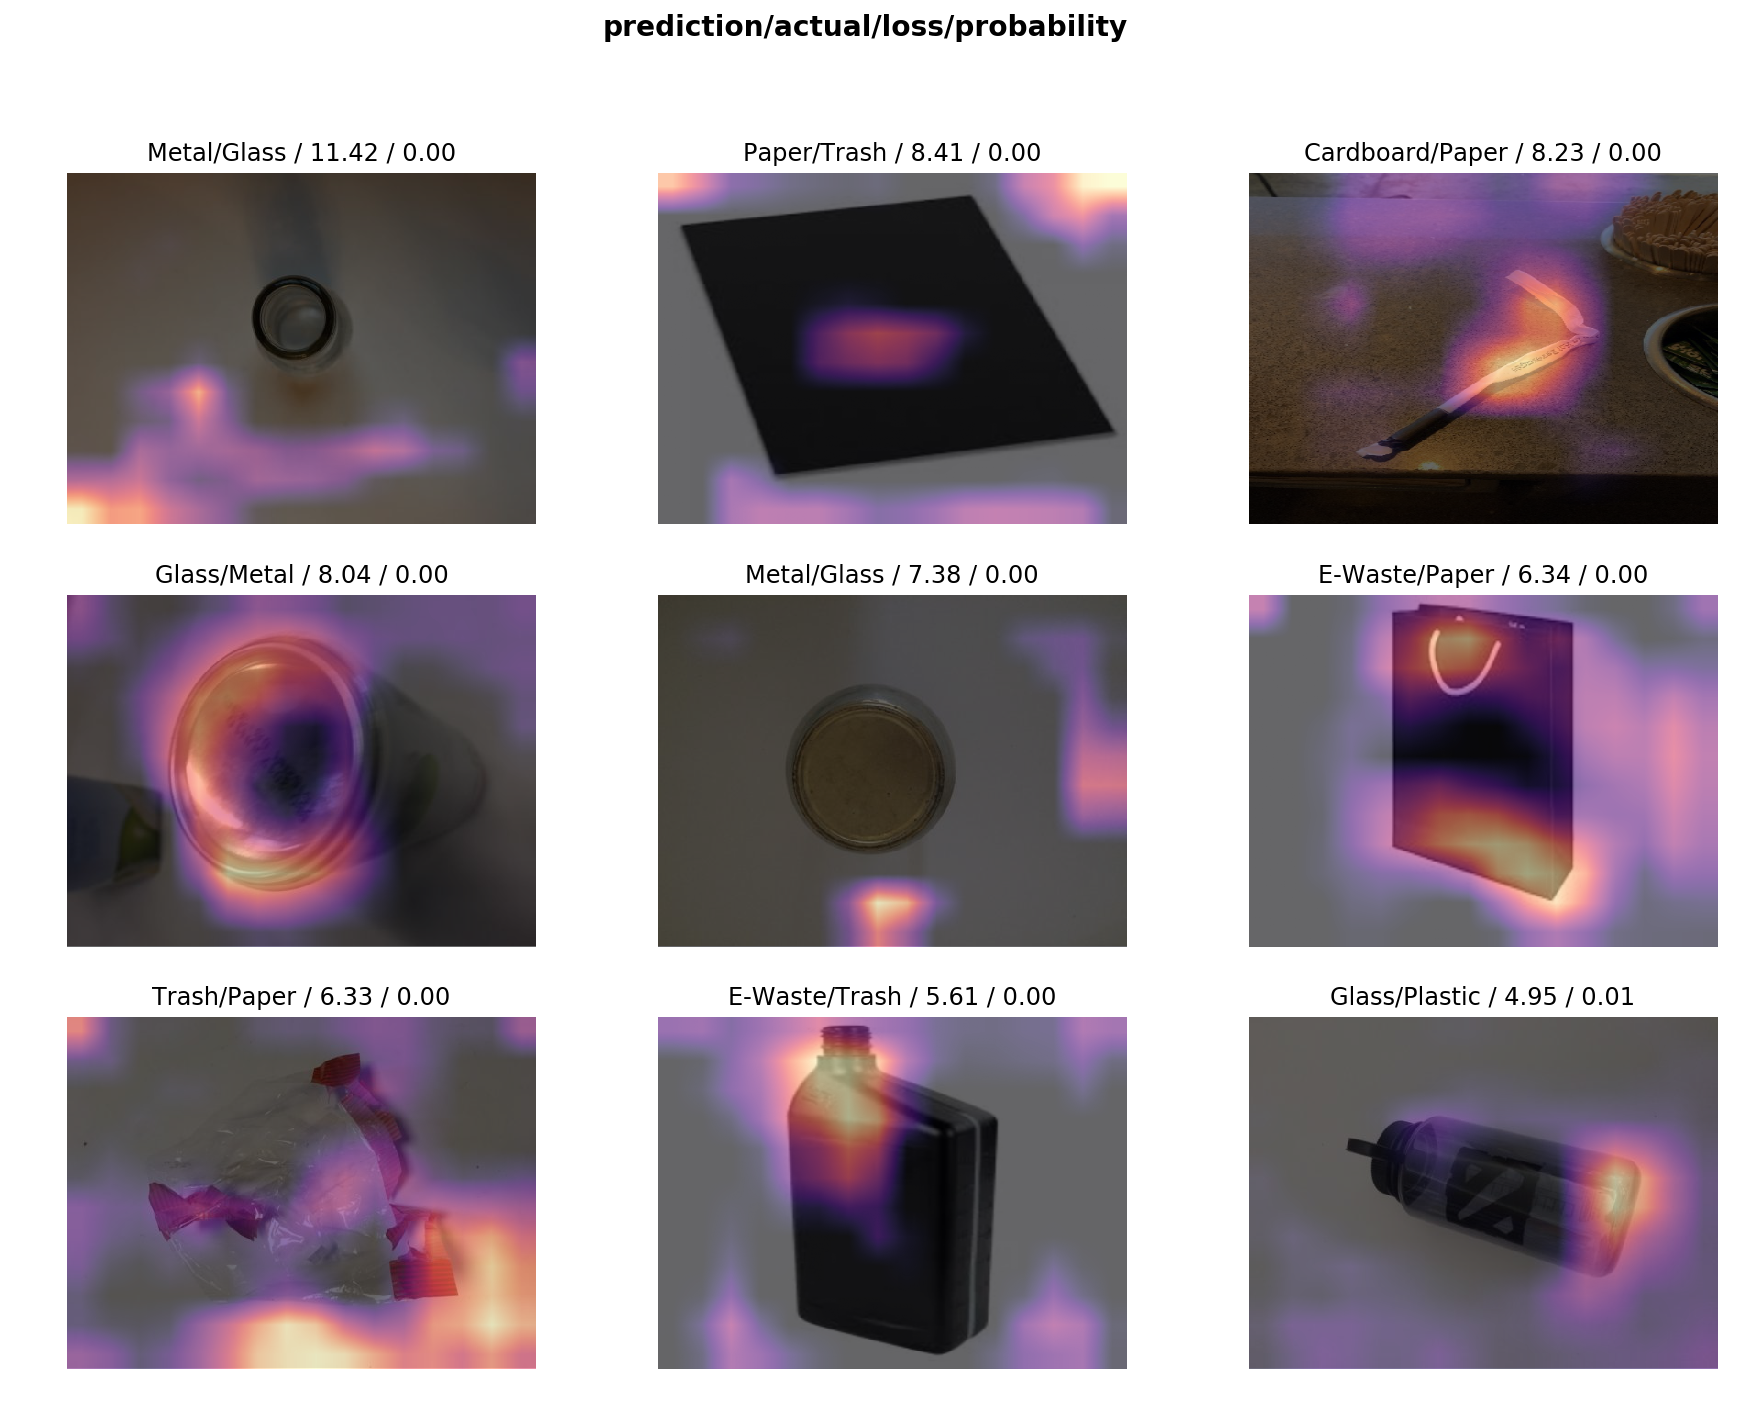

In [69]:
interp.plot_top_losses(9, figsize=(15,11))

As we can see above, the images that should have been e-waste actually included the identified material in the background.

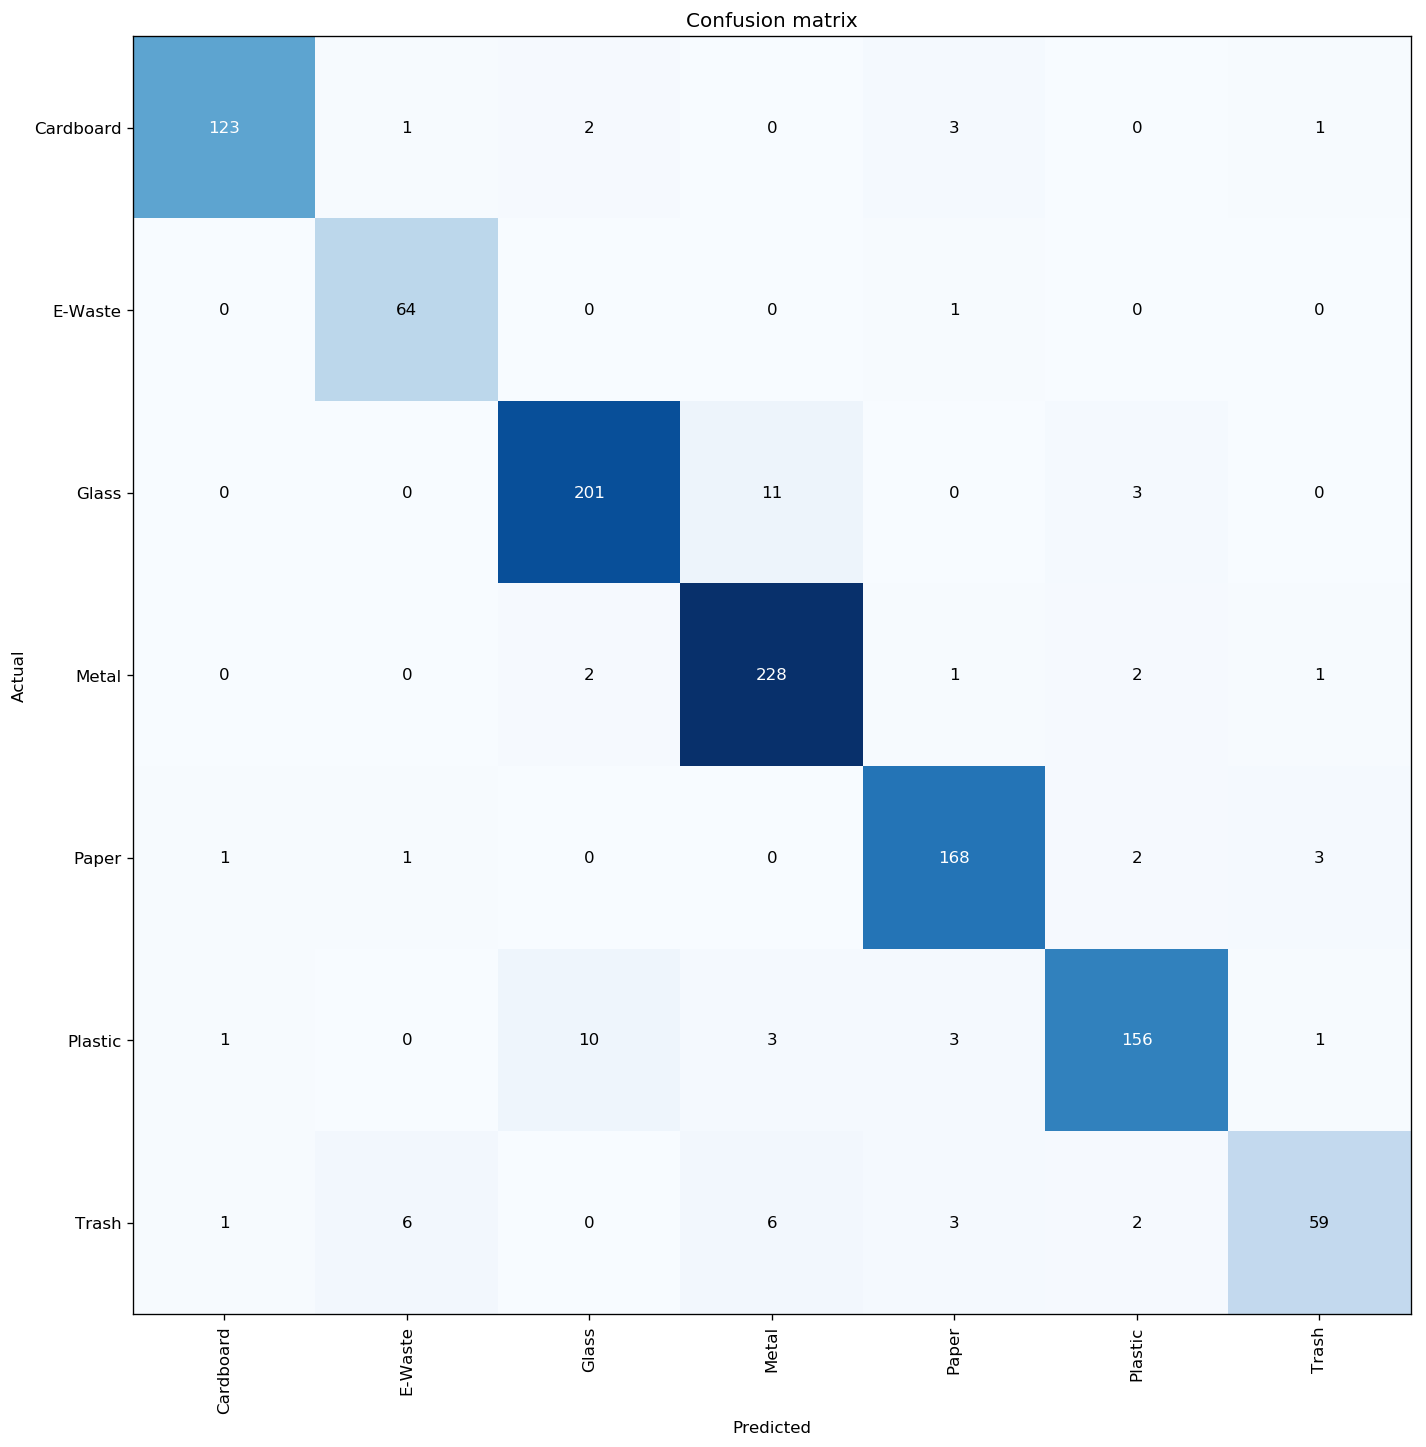

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = None , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

In [70]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

As we can see, the model most often mistook both plastic and metal for glass.

In [71]:
interp.most_confused(min_val=3)

[('Glass', 'Metal', 11),
 ('Plastic', 'Glass', 10),
 ('Trash', 'E-Waste', 6),
 ('Trash', 'Metal', 6),
 ('Cardboard', 'Paper', 3),
 ('Glass', 'Plastic', 3),
 ('Paper', 'Trash', 3),
 ('Plastic', 'Metal', 3),
 ('Plastic', 'Paper', 3),
 ('Trash', 'Paper', 3)]

## 3.4 Make new predictions on test data
In order to get an idea on how our model will extrapolate to our use-case, it is important to test it on the test data. Note that learn.get_preds will read a set of images (**DataSet type**) and return the respective predictiuons.

In [72]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [73]:
print(preds[0].shape)
preds[0]

torch.Size([1072, 7])


tensor([[1.6031e-05, 8.6416e-06, 4.6392e-03,  ..., 2.0153e-05, 9.6406e-01,
         8.6083e-06],
        [2.8367e-07, 3.1464e-06, 7.3124e-07,  ..., 5.3657e-07, 9.9994e-01,
         8.1903e-06],
        [6.7308e-06, 1.1147e-05, 1.7429e-03,  ..., 5.9638e-06, 9.9801e-01,
         4.7776e-05],
        ...,
        [1.4709e-02, 3.2754e-03, 1.1347e-02,  ..., 8.5037e-01, 1.1250e-01,
         2.5845e-03],
        [6.8692e-01, 3.2823e-04, 1.6545e-06,  ..., 3.1135e-01, 5.6417e-04,
         7.7925e-04],
        [1.2205e-04, 2.8667e-06, 1.6762e-04,  ..., 9.9967e-01, 1.9135e-05,
         1.2192e-05]])

In [74]:
data.classes

['Cardboard', 'E-Waste', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

In [75]:
## saves the index (0 to 6) of the most likely (max value) class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [76]:
yhat = [] # Our predicted classes
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [77]:
yhat[:5]

['Plastic', 'Plastic', 'Plastic', 'Plastic', 'Plastic']

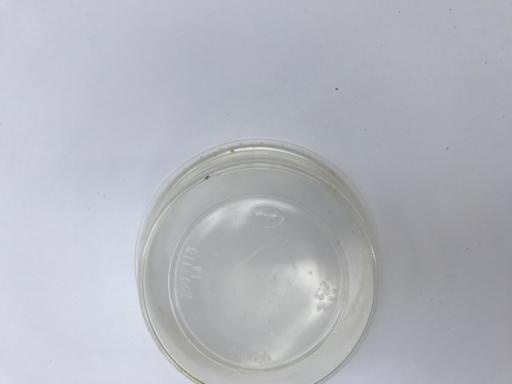

In [78]:
learn.data.test_ds[0][0]

In [79]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
print(label_path) #Model_data/test/Paper/Paper179.jpg
## then extract waste type from file path
for i in range(len(y)):
    class_r = (str(y[i]).split('/')[7]).split('.')[0]
    class_r = ''.join([i for i in class_r if not i.isdigit()])
    y[i] = class_r


/home/jupyter/Recycling/Model_data/test/Paper/Paper179.jpg


In [80]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['Plastic', 'Plastic', 'Plastic', 'Plastic', 'Plastic']
['Plastic', 'Plastic', 'Plastic', 'Plastic', 'Plastic']


In [81]:
cm = confusion_matrix(y,yhat)

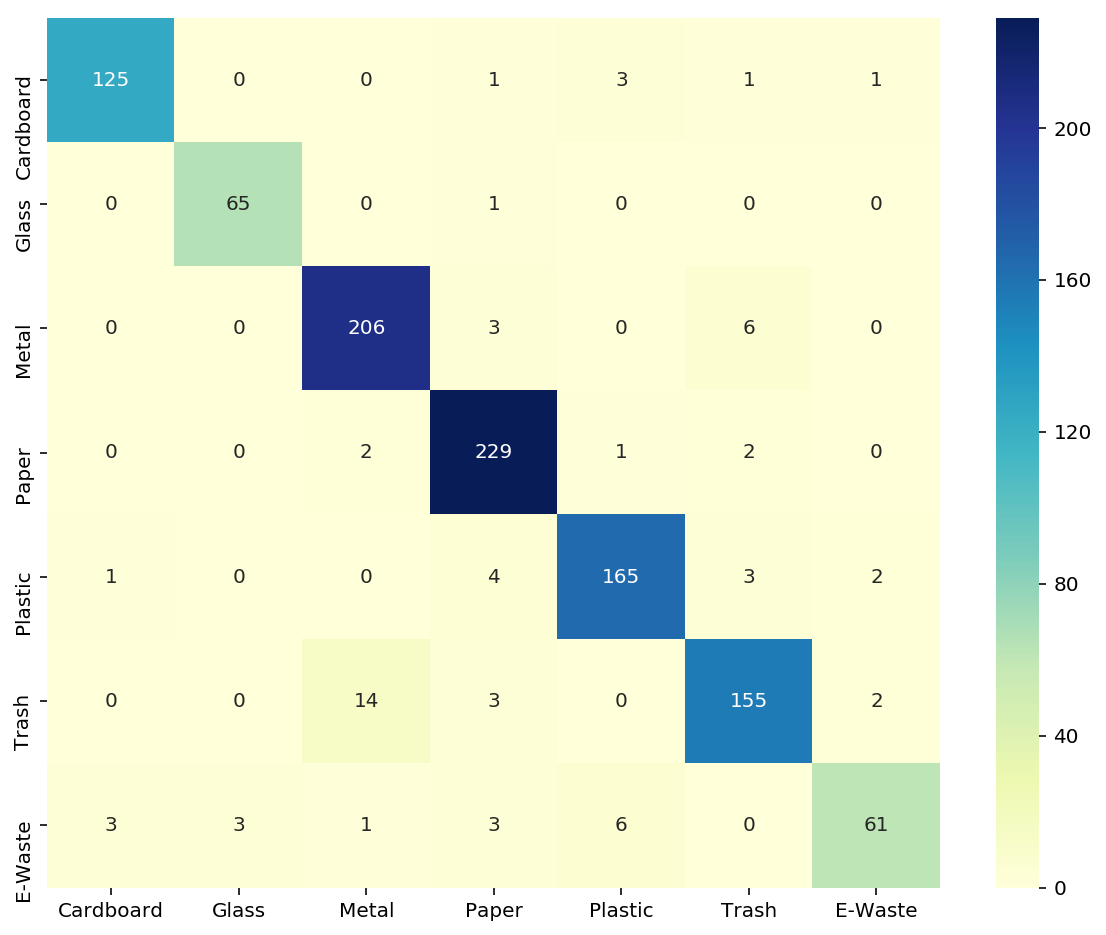

In [82]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Our confusion matrix shows us where our model made its biggest mistakes. Our two biggest issues were: mistaking 12 trash items as metal and 7 paper items as metal.

In [83]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [84]:
accuracy = correct/sum(sum(cm))
accuracy

0.9384328358208955

As we can see, our accuracy is fairly high.

In [55]:
## delete everything when you're done to save space
shutil.rmtree("total_data")
shutil.rmtree('Model_data')
shutil.rmtree('resized_AMLI')